# PLEASE ONLY USE "CELL -> RUN ALL", otherwise factors may be recalculated prior to the final model. Also i renamed the .csv's as there were grammatical errors.

# Import the libraries used:

In [55]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from IPython.display import display

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

from scipy.stats import norm

from mpl_toolkits.mplot3d import Axes3D

import math

pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.5f' % x)

np.set_printoptions(suppress = True)

plt.rcParams.update({'font.size':12, 'figure.figsize':(10, 5)}) # set font and plot sizer to be bigger


# Functions (Methods):

In [56]:
# Initial data exploration of a dataframe:
def inspect_dataset(dataset):
    display(dataset.head(2))
    display(dataset.info())
    display(dataset.shape)
    display(dataset.describe())


In [57]:
# Display all the values of each column, in order to inspect them for invalid entries:
def displayColumnValues(df):
    for column in df:
        print(column, ": ")
        print(df[column].unique(), "\n")


In [58]:
# Plot the distributions for all the columns in a df:

def plot_columns(dataframe):
    for x in dataframe:
        ax = plt.subplot()
        ax.ticklabel_format(useOffset=False, style='plain') # THIS DISABLES MATHEMATICAL NOTATION FOR LARGE INTS.
        
        sns.boxplot(dataframe[x])
        plt.show()


In [59]:
# Display all the rows with null data:
def display_null_data(dataframe):
    null_masks = dataframe.isnull().any(axis = 1)   # list of null values in any of the columns (axis = 1)
    null_data = dataframe[null_masks]
    display(null_data)  # dataframe with all rows with missing values


In [60]:
# Check to see if all the values in a column are numeric by requesting the median:
def check_if_numeric(df):
    for col in df:
        df[col].median()
    print("True")

In [61]:
# Display the IQR of a df's columns:
def display_IQR(df):
    for col in df:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        print("---------%s---------" % col)
        print("IQR: ", IQR)
        print("Q1:", Q1)
        print("Q3:", Q3)

        bot = Q1 - 1.5 * IQR
        top = Q3 + 1.5 * IQR
        rangee = top - bot
        
        print("bottom shadow:", bot)
        print("top shadow", top)
        print("range: ", rangee, "\n")


# Pre-Processing:

## Create Initial DataFrames:

In [62]:
invest_2019 = pd.read_csv("Investment_2019.csv")
invest_2018 = pd.read_csv("financial_report_2018.csv")

## Inspect the dataframes: (Commented due to size + info already gotten.)

In [63]:
#inspect_dataset(invest_2019)    # (3845, 2) - SHAPE
#invest_2019.isnull().sum()        # 2225 null values - (Investment2019)
#invest_2019.info()

#inspect_dataset(invest_2018)    # (3845, 13) - SHAPE
#invest_2018.isnull().sum()        # 28 null values - (Stock Return)
#invest_2018.info()

# DATA CLEANING:

## Cleaning the 2019 CSV:
### Finding bad values, replacing the Null values: (Investment2019)

In [64]:
# display_null_data(invest_2019)
# displayColumnValues(invest_2019)

# So as each column value only has 1 instance we will use the median to replace negative/null values.
median_investment_2019 = invest_2019['Investment2019'].median()

# Use list comprehension to find any data that is less than 0 (You cannot invest a negative amount), meaning null.
invest_2019['Investment2019'][invest_2019['Investment2019'] <= 0] = np.nan


#inspect_dataset(invest_2019)
display_null_data(invest_2019)
invest_2019.info()    # Null data final check (Stock Code will be dropped later)

,Stock Code,Investment2019
0,900939,NaN
2,900952,NaN
4,900957,NaN
5,900937,NaN
6,900928,NaN
...,...,...
3836,600653,NaN
3839,600654,NaN
3840,600602,NaN
3843,2399,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845 entries, 0 to 3844
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Stock Code      3845 non-null   int64  
 1   Investment2019  1607 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 60.2 KB


## Cleaning the 2018 CSV:

In [65]:
invest_2018.rename(columns={'Leverage ': 'Leverage'}, inplace=True)    # This column had whitespace at the end.

### Finding bad values, replacing the Null values: (Stock Return)

In [66]:
# display_null_data(invest_2018)
# displayColumnValues(invest_2018)

#invest_2018['Stock Return'].value_counts()    # 0.000000 is most common, meaning null values will be replaced with this.
invest_2018['Stock Return'].fillna(0.000000, inplace = True)    # minus numbers are allowed (negative returns)

display_null_data(invest_2018)


,Stock Code,Market Value of Equity,Total Market Value,Stock Return,Total Investment Expenditure,Amortization and Depreciation,Book Value,Operating Income after Depreciation,Annual Dividends,Leverage,Cash,Age,Size


### Finding bad values, changing Dtype: (Size)

In [67]:
# invest_2018['Size'].value_counts()    # this is unhelpful as there are multiple values with 3 entries, so use median.

invest_2018['Size'][invest_2018['Size'] == "#NUM!"] = np.nan    # Non-numeric.

median_size = invest_2018['Size'].median()

invest_2018['Size'].fillna(median_size, inplace = True)    # Use median for null values.

invest_2018['Size'] = pd.to_numeric(invest_2018['Size'])

display_null_data(invest_2018)

invest_2018.info()    # Null data final check

,Stock Code,Market Value of Equity,Total Market Value,Stock Return,Total Investment Expenditure,Amortization and Depreciation,Book Value,Operating Income after Depreciation,Annual Dividends,Leverage,Cash,Age,Size


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845 entries, 0 to 3844
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Stock Code                           3845 non-null   int64  
 1   Market Value of Equity               3845 non-null   float64
 2   Total Market Value                   3845 non-null   float64
 3   Stock Return                         3845 non-null   float64
 4   Total Investment Expenditure         3845 non-null   float64
 5   Amortization and Depreciation        3845 non-null   float64
 6   Book Value                           3845 non-null   float64
 7   Operating Income after Depreciation  3845 non-null   float64
 8   Annual Dividends                     3845 non-null   float64
 9   Leverage                             3845 non-null   float64
 10  Cash                                 3845 non-null   float64
 11  Age                           

## This function is an easy check to make sure no non numeric values are lurking in the huge databases, if there is it will fail.

In [68]:
check_if_numeric(invest_2019)
check_if_numeric(invest_2018)

True
True


# Aggregate the databases to a .csv:

In [69]:
# Check values before:
invest_2019.head(2)
invest_2018.head(2)

# Merge into new DF:
combined_investments = pd.DataFrame()
combined_investments = pd.merge(invest_2019, invest_2018, how = 'outer')

# Check values after:
combined_investments.head(1)
type(combined_investments)

# Check shape prior + after dropping np.nan's.
combined_investments.shape
combined_investments.dropna(inplace = True)
combined_investments.shape
combined_investments.head(2)

combined_investments.to_csv("samples_for_regression.csv")


,Stock Code,Investment2019
0,900939,NaN
1,900956,426.65225


,Stock Code,Market Value of Equity,Total Market Value,Stock Return,Total Investment Expenditure,Amortization and Depreciation,Book Value,Operating Income after Depreciation,Annual Dividends,Leverage,Cash,Age,Size
0,900939,57992.00000,119608.50000,0.08925,736.49840,529.17700,18557.44000,3618.70080,767.16457,0.77995,2109.89394,1.23045,6.16485
1,900956,153180.00000,313020.00000,0.07394,1945.38600,1282.88250,75058.20000,12609.77760,3366.81062,0.75709,2983.08060,0.00000,7.48570


,Stock Code,Investment2019,Market Value of Equity,Total Market Value,Stock Return,Total Investment Expenditure,Amortization and Depreciation,Book Value,Operating Income after Depreciation,Annual Dividends,Leverage,Cash,Age,Size
0,900939,NaN,57992.00000,119608.50000,0.08925,736.49840,529.17700,18557.44000,3618.70080,767.16457,0.77995,2109.89394,1.23045,6.16485


pandas.core.frame.DataFrame

(3845, 14)

(1607, 14)

,Stock Code,Investment2019,Market Value of Equity,Total Market Value,Stock Return,Total Investment Expenditure,Amortization and Depreciation,Book Value,Operating Income after Depreciation,Annual Dividends,Leverage,Cash,Age,Size
1,900956,426.65225,153180.00000,313020.00000,0.07394,1945.38600,1282.88250,75058.20000,12609.77760,3366.81062,0.75709,2983.08060,0.00000,7.48570
3,900933,14590.06190,1526013.44000,1526013.44000,0.07117,24721.41773,14497.12768,656185.77920,131237.15580,26247.43117,0.43887,83686.57705,0.47712,6.54998


# Read in the new dataframe from the merged .csv:

In [70]:
regression_samples = pd.read_csv("samples_for_regression.csv")
del regression_samples['Unnamed: 0']    # This just gets rid of the extra index (0) column that was written with the merge.

regression_samples.head()

,Stock Code,Investment2019,Market Value of Equity,Total Market Value,Stock Return,Total Investment Expenditure,Amortization and Depreciation,Book Value,Operating Income after Depreciation,Annual Dividends,Leverage,Cash,Age,Size
0,900956,426.65225,153180.00000,313020.00000,0.07394,1945.38600,1282.88250,75058.20000,12609.77760,3366.81062,0.75709,2983.08060,0.00000,7.48570
1,900933,14590.06190,1526013.44000,1526013.44000,0.07117,24721.41773,14497.12768,656185.77920,131237.15580,26247.43117,0.43887,83686.57705,0.47712,6.54998
2,900953,257.64200,114720.00000,305920.00000,0.06459,1300.16000,1132.86000,26385.60000,6306.15840,1690.05045,0.46263,7210.53440,0.47712,5.95208
3,900951,380.72475,35000.00000,96250.00000,-0.03581,500.50000,319.37500,5600.00000,1430.80000,283.29840,1.01519,1785.43750,1.38021,5.57385
4,900922,385.75051,31516.53000,31516.53000,0.03195,485.35456,185.15961,5042.64480,950.53854,182.50340,1.27798,820.69044,1.07918,5.70060


## Plotting the distribution of the new aggregated CSV:

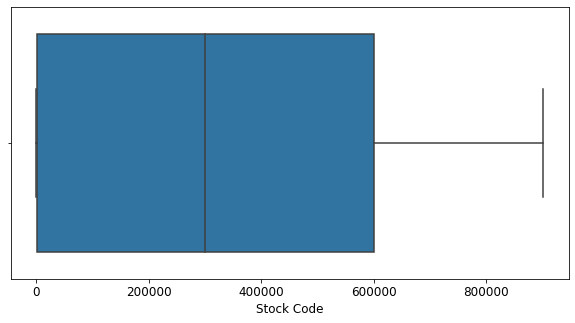

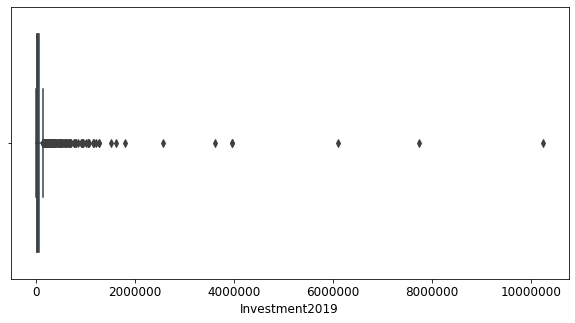

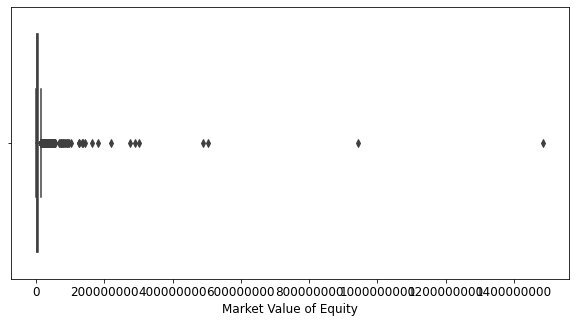

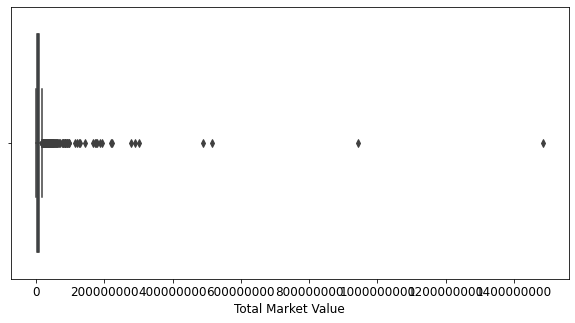

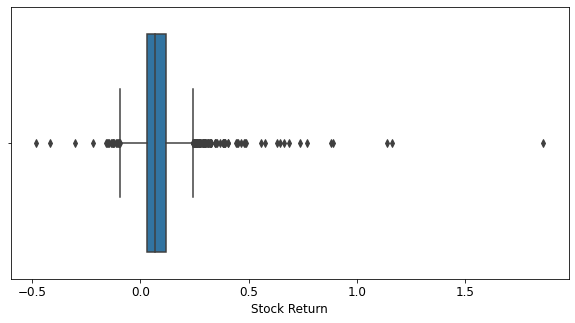

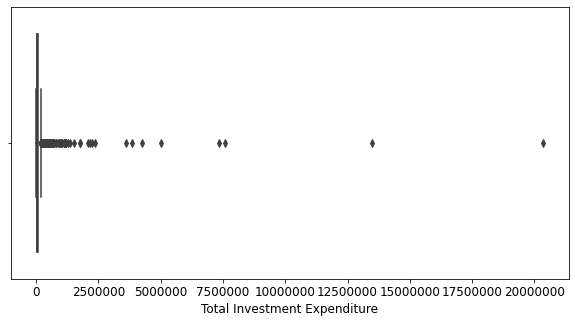

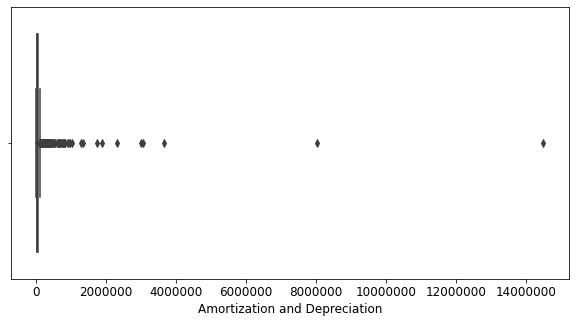

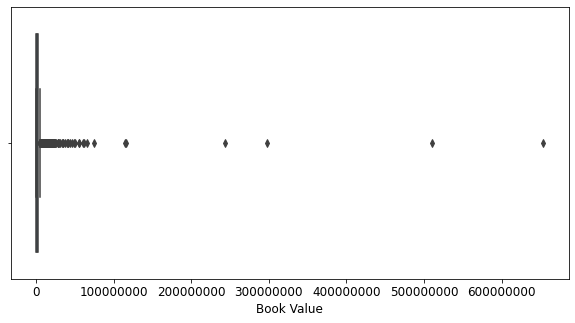

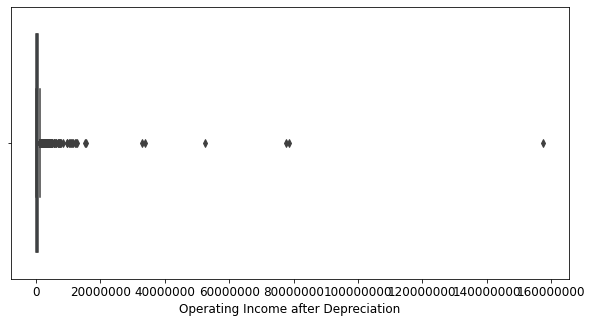

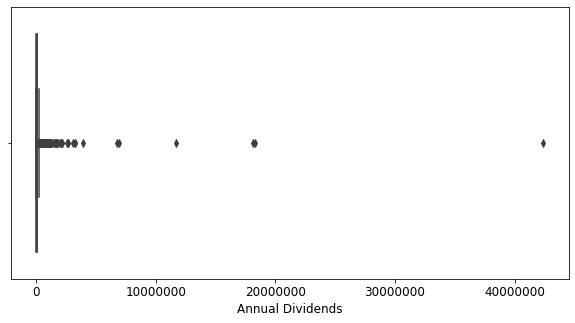

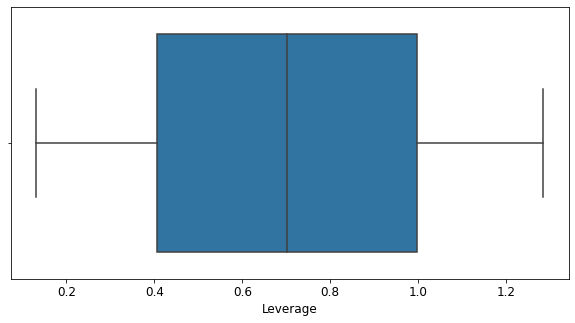

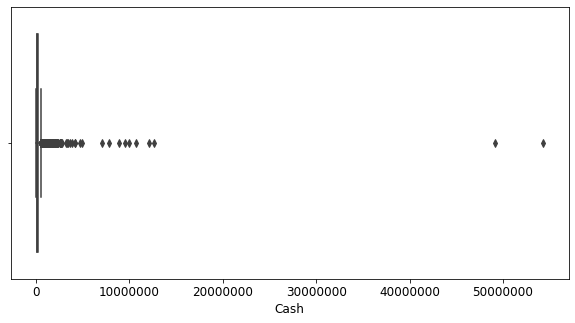

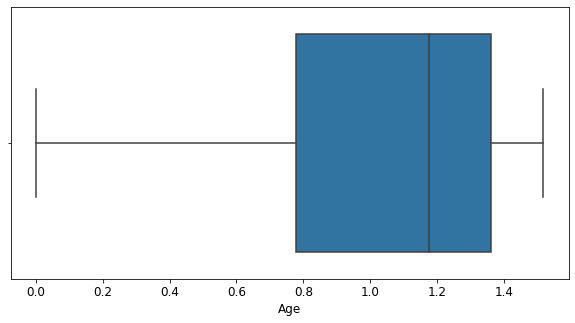

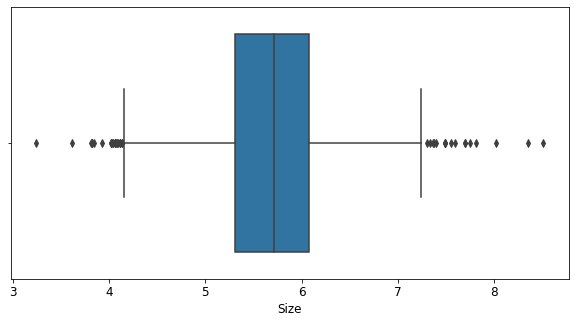

In [71]:
plot_columns(regression_samples)    # Plots the Boxplot Distributions for all columns in the newly merged DF.

## Descriptive statistic summary:

In [72]:
regression_samples.describe()    # Numerical info

display_IQR(regression_samples)    # IQR + range info.

,Stock Code,Investment2019,Market Value of Equity,Total Market Value,Stock Return,Total Investment Expenditure,Amortization and Depreciation,Book Value,Operating Income after Depreciation,Annual Dividends,Leverage,Cash,Age,Size
count,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000,1607.00000
mean,321838.37834,98981.52387,10083395.90927,12164137.94314,0.08627,138203.08682,80072.19751,4025870.74646,898375.64674,201256.88754,0.70428,364682.49175,1.04459,5.68297
std,278152.41551,422004.77205,50835640.10769,51833364.15097,0.11499,716284.62509,454789.67937,23795829.99373,5250996.76893,1320404.16322,0.33767,1995346.48865,0.41726,0.65597
min,8.00000,34.17340,24128.61000,24128.61000,-0.48260,398.12207,177.94850,4825.72200,950.53854,182.50340,0.13082,116.54119,0.00000,3.24265
25%,2512.00000,12823.87616,1701144.50000,2633001.16500,0.03220,20411.62806,12708.86678,551810.81985,120477.86875,25824.62249,0.40607,53478.19702,0.77815,5.30550
50%,300521.00000,27783.61698,3018301.92000,4251753.07000,0.06711,40662.10106,23947.30916,1126956.60000,251945.35480,52012.41771,0.70243,111193.03480,1.17609,5.71000
75%,600966.50000,64603.13716,6573004.11000,8631754.34500,0.11619,88086.77780,50029.23602,2511407.63500,560347.51760,116466.12690,0.99865,235952.57955,1.36173,6.07877
max,900956.00000,10254931.74000,1486081997.00000,1486081997.00000,1.86317,20359323.36000,14489299.47000,653876078.90000,157584135.00000,42390132.32000,1.28498,54316297.00000,1.51851,8.50990


---------Stock Code---------
IQR:  598454.5
Q1: 2512.0
Q3: 600966.5
bottom shadow: -895169.75
top shadow 1498648.25
range:  2393818.0 

---------Investment2019---------
IQR:  51779.26099
Q1: 12823.876165
Q3: 64603.137155000004
bottom shadow: -64845.01532
top shadow 142272.02864
range:  207117.04396 

---------Market Value of Equity---------
IQR:  4871859.609999999
Q1: 1701144.5
Q3: 6573004.109999999
bottom shadow: -5606644.914999999
top shadow 13880793.524999999
range:  19487438.439999998 

---------Total Market Value---------
IQR:  5998753.179999999
Q1: 2633001.165
Q3: 8631754.344999999
bottom shadow: -6365128.604999998
top shadow 17629884.114999995
range:  23995012.71999999 

---------Stock Return---------
IQR:  0.08398800000000001
Q1: 0.032197
Q3: 0.11618500000000001
bottom shadow: -0.09378500000000001
top shadow 0.24216700000000002
range:  0.33595200000000003 

---------Total Investment Expenditure---------
IQR:  67675.149745
Q1: 20411.628055
Q3: 88086.77780000001
bottom shadow: -8

# Regression Analysis.

In [73]:
regression_samples.head(1)    # This is just for easy reading of the feature names.

,Stock Code,Investment2019,Market Value of Equity,Total Market Value,Stock Return,Total Investment Expenditure,Amortization and Depreciation,Book Value,Operating Income after Depreciation,Annual Dividends,Leverage,Cash,Age,Size
0,900956,426.65225,153180.00000,313020.00000,0.07394,1945.38600,1282.88250,75058.20000,12609.77760,3366.81062,0.75709,2983.08060,0.00000,7.48570


## Reshape the data, so it can be normalised.

In [74]:
#Stock_Codes = regression_samples['Stock Code'].values.reshape(-1, 1)

Investment2019 = regression_samples['Investment2019'].values.reshape(-1, 1)

Market_Value_Of_Equity2018 = regression_samples['Market Value of Equity'].values.reshape(-1, 1)

Total_Market_Value2018 = regression_samples['Total Market Value'].values.reshape(-1, 1) #!!!!!!

Stock_Returns2018 = regression_samples['Stock Return'].values.reshape(-1, 1)

Total_Investment_Expenditure2018 = regression_samples['Total Investment Expenditure'].values.reshape(-1, 1)

Amortization_And_Depreciation2018 = regression_samples['Amortization and Depreciation'].values.reshape(-1, 1)

Book_Value2018 = regression_samples['Book Value'].values.reshape(-1, 1)

Operating_Income_After_Depreciation2018 = regression_samples['Operating Income after Depreciation'].values.reshape(-1, 1)

Annual_Dividends2018 = regression_samples['Annual Dividends'].values.reshape(-1, 1)

Leverage2018 = regression_samples['Leverage'].values.reshape(-1, 1)

Cash2018 = regression_samples['Cash'].values.reshape(-1, 1)

Age2018 = regression_samples['Age'].values.reshape(-1, 1)

Size2018 = regression_samples['Size'].values.reshape(-1, 1)


# Calculate the sub elements for equation 2:
VP2018 = ((1 - 1.24 * 0.12) * Book_Value2018 + 1.24 * 1.12 * Operating_Income_After_Depreciation2018 - 1.24 * 0.12 * 
          Annual_Dividends2018) / Market_Value_Of_Equity2018

Investment2018 = Total_Investment_Expenditure2018 - Amortization_And_Depreciation2018


## Normalise the data with varied ranges to the same range:

In [75]:
# Scalers----
Investment2019_scaler = MinMaxScaler()

VP_scaler = MinMaxScaler()
Leverage_scaler = MinMaxScaler()
Cash_scaler = MinMaxScaler()
Age_scaler = MinMaxScaler()
Size_scaler = MinMaxScaler()
Stock_Returns_scaler = MinMaxScaler()
Investment2018_scaler = MinMaxScaler()

# Normalised features
norm_Investment2019 = Investment2019_scaler.fit_transform(Investment2019).reshape(-1)

norm_VP = VP_scaler.fit_transform(VP2018).reshape(-1)
norm_Leverage = Leverage_scaler.fit_transform(Leverage2018).reshape(-1)
norm_Cash = Cash_scaler.fit_transform(Cash2018).reshape(-1)
norm_Age = Age_scaler.fit_transform(Age2018).reshape(-1)
norm_Size = Size_scaler.fit_transform(Size2018).reshape(-1)
norm_Stock_Returns = Stock_Returns_scaler.fit_transform(Stock_Returns2018).reshape(-1)
norm_Investment2018 = Investment2018_scaler.fit_transform(Investment2018).reshape(-1)


# Graphing of the initial normalised data - 7th variable cannot be included (norm_Investment2018)

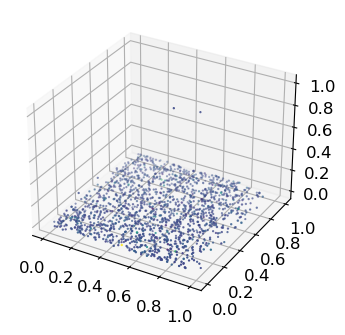

In [76]:
graphWidth = 400    
graphHeight = 300

# 6 Features in 3D Space. 

f = plt.figure(figsize = (graphWidth / 100.0, graphHeight / 100.0), dpi = 100)
axes = Axes3D(f)
axes.scatter(norm_VP, norm_Leverage, norm_Cash, norm_Age, norm_Size, norm_Stock_Returns)
plt.show();

## Fit the data, calculate R2 Score, Errors(Metrics) and coefficients for later use.

In [77]:
x_y_data_d = np.array((norm_VP, norm_Leverage, norm_Cash, norm_Age, norm_Size, norm_Stock_Returns, norm_Investment2018)).T
print("Total shape of features: ", x_y_data_d.shape)    # (1607, 7)
x_y_data_d = np.reshape(x_y_data_d, (1607, 7))

model = LinearRegression().fit(x_y_data_d, norm_Investment2019)
print("\n", "Coefficient: ", model.coef_, "\n Intercept: ", model.intercept_, "\n") 

y = np.array((norm_Investment2019)).T
y_pred = model.predict(x_y_data_d)

R2_score = r2_score(y, y_pred)
print("R2 score: ", R2_score)

print()
print("------------Errors-------------")
print('Mean Absolute Error:', metrics.mean_absolute_error(norm_Investment2019, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(norm_Investment2019, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(norm_Investment2019, y_pred)))

# Initial Coef + intercept for the linear model.
parameters = [0.00246073, -0.00186629,  0.24632236, -0.00088496, -0.01204566, 0.0001159, 0.11838744, 0.00437020162117006]


Total shape of features:  (1607, 7)

 Coefficient:  [ 0.00251317  0.00085292  0.14835297  0.00225933 -0.0111714  -0.00092247
  0.72114209] 
 Intercept:  -0.03346429142157577 

R2 score:  0.8524018670658543

------------Errors-------------
Mean Absolute Error: 0.005095102787781757
Mean Squared Error: 0.0002497943429217485
Root Mean Squared Error: 0.015804883514969306


# Plot Initial errors - R2.

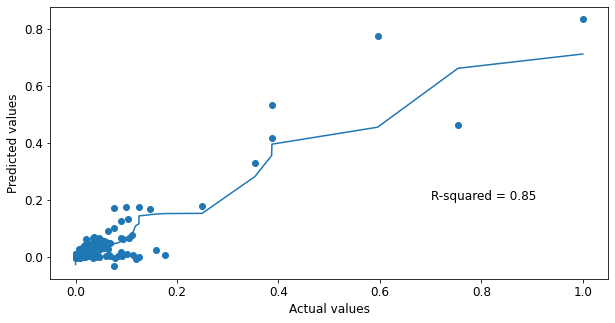

In [78]:
plt.scatter(y, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y), np.poly1d(np.polyfit(y, y_pred, 1))(np.unique(y_pred)))

plt.text(0.7, 0.2, 'R-squared = %0.2f' % R2_score)
plt.show();

## Calculate the correct regression plane using gradient descent

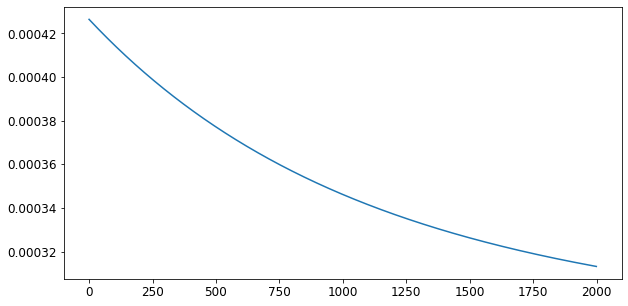

[ 0.0033223   0.00089154  0.50215747  0.00455477 -0.00519602  0.0768879
  0.4885052  -0.04518489]


In [79]:
parameters = [1, 1, 1, 1, 1, 1, 1, 1]

alpha = 0.1    # a

x = np.array([norm_VP, norm_Leverage, norm_Cash, norm_Age, norm_Size, norm_Stock_Returns, 
              norm_Investment2018, np.full(len(norm_VP), 1)]).T

y = norm_Investment2019

loss_history = []

# The linear model ax + b
def h(x):
    return np.sum(parameters * x, axis = 1)

# MSE loss function
def loss(y_hat, y):
    return np.sum(np.square(y - y_hat)) / len(y)

# Calculate the current gradient
def gradient(x, y_hat, y):
    # (y - y_hat) is a 1d array shape = (full_data_length), it cannot multiply x,
    # therefore it must be reshaped to [full_data_length, 1] (2D)
    
    # returns a numpy array [gradients for w1, w2, w3...]
    return -2 / len(y) * np.sum(x * (y - y_hat).reshape((y-y_hat).shape[0], 1), axis = 0)


for i in range(0, 5000):
    y_hat = h(x)
    parameters = parameters - alpha * gradient(x, y_hat, y)
    loss_history = loss_history + [loss(y_hat, y)]

plt.plot(loss_history[-2000:])
plt.show();

print(parameters)    # Optimal Parameters, where value is closest to zero, before flattening completely.


## Evaluate the model using K-Fold-Cross-Validation

In [80]:
# This evaluates the efficacy of the LinearRegression model with the Gradient Descent's Optimal Parameters.

kf = KFold(n_splits = 10)
r2_scores = []
counter = 0

# kf.split(x) automatically generates array index for train and test data for 10 folds
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # start training 5000 times for one fold
    for i in range(0, 5000):
        # calculate the predicted y, for all x
        y_hat = h(x_train)
        
        # update the whole parameter list using the latest gradient
        parameters = parameters - alpha * gradient(x_train, y_hat, y_train)
    
    # Test the model using x_test and y_test, calculate the r2 score
    r2_scores = r2_scores + [r2_score(y_test, h(x_test))]
    print("R2 score for the ", counter, " fold: ", r2_score(y_test, h(x_test)))
    
    counter = counter + 1


mean_r2 = np.mean(r2_scores)
print("Mean R2 Score: ", mean_r2)    # (0.579772940140613)

n = 5000    # Size of fold
p = 7       # Number of features
Adj_r2 = 1-(1-mean_r2)*(n-1)/(n-p-1)
print("Adjusted R2 Score: ", Adj_r2) # (0.5791836794396883)


R2 score for the  0  fold:  0.9459733428495366
R2 score for the  1  fold:  0.6867846525375038
R2 score for the  2  fold:  0.310540667304276
R2 score for the  3  fold:  0.7605876643624463
R2 score for the  4  fold:  -0.008995601468472003
R2 score for the  5  fold:  0.732536567641318
R2 score for the  6  fold:  0.7732074972533949
R2 score for the  7  fold:  0.28007010883182626
R2 score for the  8  fold:  0.38759100442295225
R2 score for the  9  fold:  0.9294334976713476
Mean R2 Score:  0.579772940140613
Adjusted R2 Score:  0.5791836794396883


# Calculate The Expected Investment 2019, and determine overinvested companies.

In [81]:
a = alpha

# This uses the optimal parameters from the gradient descent cell, as well as the normalised data to give us the EI2019.
pred = (a + (0.0033223 * VP2018) + (0.00089154 * Leverage2018) + (0.50215747 * Cash2018) + (0.00455477 * Age2018) + 
    (-0.00519602 * Size2018) + (0.0768879 * Stock_Returns2018) + (0.4885052 * Investment2018))

# Turn the data from numpy.nd array to pd.DF
Expected_Investment2019 = pd.DataFrame(pred)
Expected_Investment2019.rename(columns = {0 : 'Expected Investment 2019'}, inplace = True)

# Calculate investment value in new DF.
Investment_Amounts = pd.DataFrame()
Investment_Amounts['Investment 2019'] = regression_samples['Investment2019']
Investment_Amounts['Expected Investment 2019'] = Expected_Investment2019['Expected Investment 2019']
Investment_Amounts['Overinvestment'] = Investment_Amounts['Investment 2019']-Investment_Amounts['Expected Investment 2019']

# Final DF with stock code and the overinvested values of companies that are overinvested only.
Overinvestment_2019 = pd.DataFrame()
Overinvestment_2019['Stock Code'] = regression_samples['Stock Code']
Overinvestment_2019['Overinvestment Value'] = Investment_Amounts['Overinvestment'][Investment_Amounts['Overinvestment'] >0]
Overinvestment_2019.dropna(inplace = True)
Overinvestment_2019.set_index("Stock Code", inplace = True)

Overinvestment_2019.head(2)

# Console output of results.
non_null = len(Expected_Investment2019['Expected Investment 2019'])
no_overinvested = len(Overinvestment_2019['Overinvestment Value'])    # 293 Overinvested Companies, from the LR() Model.

print("Out of %d non-Null companies, %d are overinvested." % (non_null, no_overinvested))

# Write the data to the end csv.
Overinvestment_2019.to_csv("./overinvestment_2019.csv")


,Overinvestment Value
Stock Code,
900947,19075.51026
600759,29675.49133


Out of 1607 non-Null companies, 293 are overinvested.
